In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.morphology import binary_erosion
from scipy.spatial import Voronoi
from shapely.geometry import Point, Polygon
from skimage import draw
from sklearn.neighbors import KDTree

In [2]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [67]:
np.random.seed(1234)
#points = np.random.rand(3, 2)

points=np.array([[-0.5,-0.4],[0.2,0.5],[0.6,0.1],[-0.4,0.5]])
# compute Voronoi tesselation
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

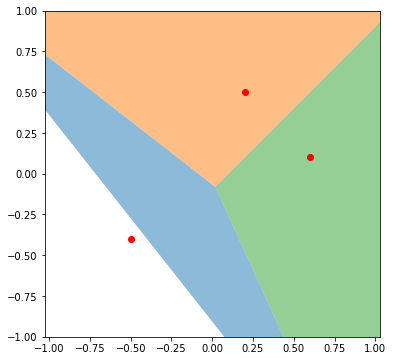

In [22]:
# colorize
plt.figure(figsize=(6,6))

for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.5)

plt.plot(points[:,0], points[:,1], 'ro')

plt.axis('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

#plt.savefig('voro.png')
plt.show()

In [23]:
regions

[[2, 0, 1], [0, 3, 4], [6, 5, 0]]

In [24]:
vertices

array([[ 0.01875   , -0.08125   ],
       [-1.71782488,  1.26941935],
       [ 0.92911648, -2.08405625],
       [ 1.57438492,  1.47438492],
       [-1.71782488,  1.26941935],
       [ 1.57438492,  1.47438492],
       [ 0.92911648, -2.08405625]])

In [25]:
polygon=vertices[regions[0]]

In [26]:
polygon

array([[ 0.92911648, -2.08405625],
       [ 0.01875   , -0.08125   ],
       [-1.71782488,  1.26941935]])

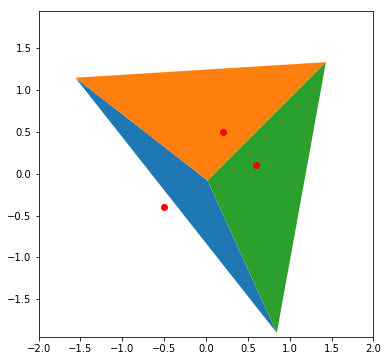

In [35]:
# colorize
regions, vertices = voronoi_finite_polygons_2d(vor,2.0)

plt.figure(figsize=(6,6))

for region in regions:
    polygon = vertices[region]
    
    #plt.plot(polygon[:,0],polygon[:,1])
    plt.fill(polygon[:,0],polygon[:,1])
    
    #plt.fill(*zip(*polygon), alpha=0.5)

plt.plot(points[:,0], points[:,1], 'ro')

plt.axis('equal')
plt.xlim(-2, 2)
plt.ylim(-2, 2)

#plt.savefig('voro.png')
plt.show()

In [36]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [124]:
#points=np.array([[-0.5,-0.4],[0.2,0.5],[0.6,0.1],[-0.4,0.5]])
points=np.array([[-0.5,-0.4],[0.2,0.5],[-0.4,0.5]])
# compute Voronoi tesselation
vor = Voronoi(points)


<Figure size 432x432 with 0 Axes>

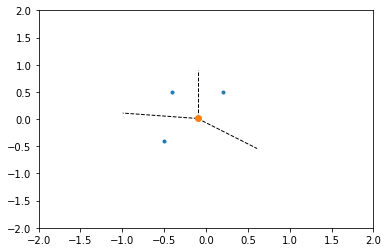

In [125]:
plt.figure(figsize=(6,6))
voronoi_plot_2d(vor)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

In [42]:
vor.vertices

array([[ 0.01875, -0.08125]])

In [43]:
vor.regions

[[], [-1, 0], [-1, 0], [-1, 0]]

In [44]:
vor.points

array([[-0.5, -0.4],
       [ 0.2,  0.5],
       [ 0.6,  0.1]])

In [47]:
vor.point_region

array([3, 1, 2], dtype=int64)

In [48]:
vor.ridge_points

array([[1, 2],
       [1, 0],
       [2, 0]], dtype=int32)

In [49]:
vor.ridge_vertices

[[-1, 0], [-1, 0], [-1, 0]]

In [50]:
vor.npoints

3

In [51]:
vor.ridge_dict

{(1, 0): [-1, 0], (1, 2): [-1, 0], (2, 0): [-1, 0]}

In [52]:
vor.max_bound

array([ 0.6,  0.5])

In [53]:
vor.min_bound

array([-0.5, -0.4])

In [54]:
line_segments = []
for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    if np.all(simplex >= 0):
        line_segments.append([(x, y) for x, y in vor.vertices[simplex]])

In [55]:
line_segments

[]

In [62]:
def get_dash_line(vor):
    line_segments = []
    center = vor.points.mean(axis=0)
    ptp_bound = vor.points.ptp(axis=0)
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.any(simplex < 0):
            i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[i] + direction * ptp_bound.max()

            line_segments.append([(vor.vertices[i, 0], vor.vertices[i, 1]),
                                  (far_point[0], far_point[1])])
    return line_segments

In [127]:
line_dash=get_dash_line(vor)

In [73]:
line_dash

[[(-0.099999999999999978, 0.011111111111111127),
  (-0.099999999999999978, 1.1111111111111112)],
 [(-0.099999999999999978, 0.011111111111111127),
  (-1.1932721081409809, 0.13258578979344229)],
 [(0.018749999999999989, -0.081250000000000044),
  (0.79656745930520234, 0.69656745930520225)],
 [(0.018749999999999989, -0.081250000000000044),
  (0.47393323873130239, -1.0826531252088654)]]

In [66]:
def get_solid_line(vor):
    line_segments = []
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            line_segments.append([(x, y) for x, y in vor.vertices[simplex]])
    return line_segments

In [126]:
line_solid=get_solid_line(vor)

In [80]:
l=line_solid[0]

In [86]:
l[0][0],l[0][1]

(0.018749999999999989, -0.081250000000000044)

In [95]:
l[0]

(0.018749999999999989, -0.081250000000000044)

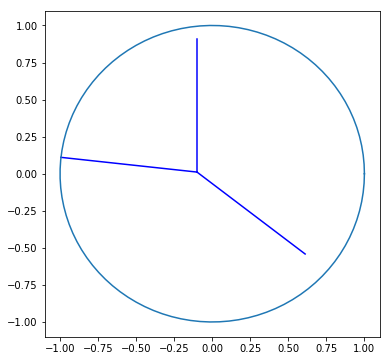

In [128]:
plt.figure(figsize=(6,6))

#voronoi_plot_2d(vor)

for line in line_solid:
    plt.plot([line[0][0],line[1][0]],[line[0][1],line[1][1]],c='r')
    #plt.scatter([line[0][0],line[1][0]],[line[0][1],line[1][1]],c='g')
    plt.scatter(line[0][0],line[0][1],c='g')
    plt.scatter(line[1][0],line[1][1],c='g')

for line in line_dash:
    #plt.plot(line[0],line[1],c='b')
    plt.plot([line[0][0],line[1][0]],[line[0][1],line[1][1]],c='b')

t=np.linspace(0,2*np.pi,100)
plt.plot(np.cos(t),np.sin(t))
    
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.show()

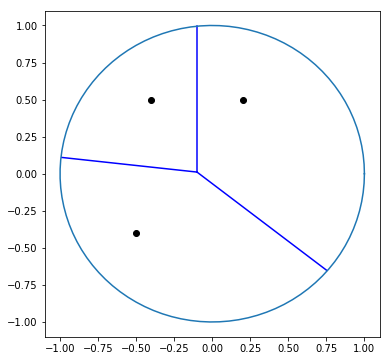

In [129]:
plt.figure(figsize=(6,6))

#voronoi_plot_2d(vor)

for line in line_solid:
    plt.plot([line[0][0],line[1][0]],[line[0][1],line[1][1]],c='r')
    #plt.scatter([line[0][0],line[1][0]],[line[0][1],line[1][1]],c='g')
    plt.scatter(line[0][0],line[0][1],c='g')
    plt.scatter(line[1][0],line[1][1],c='g')

for line in line_dash:
    #plt.plot(line[0],line[1],c='b')
    x1=line[0][0]
    y1=line[0][1]
    x2=line[1][0]
    y2=line[1][1]
    #plt.plot([x1,x2],[y1,y2],c='b')
    li=intersect_circle(x1,y1,x2-x1,y2-y1)
    plt.plot([li[0][0],li[1][0]],[li[0][1],li[1][1]],c='b')

t=np.linspace(0,2*np.pi,100)
plt.plot(np.cos(t),np.sin(t))
    
plt.scatter(points[:,0],points[:,1],c='k')
    
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.show()

In [106]:
def intersect_circle1(x0,y0,a,b):
    delta=(a*a+b*b)*(1-x0*x0-y0*y0)
    t=(-(a*x0+b*y0)+np.sqrt(delta))/(a*a+b*b)
    x1=x0+t*a
    y1=y0+t*b
    return [(x0,y0),(x1,y1)]

In [111]:
line=line_dash[0]
x1=line[0][0]
y1=line[0][1]
x2=line[1][0]
y2=line[1][1]

In [112]:
x0=x1
y0=y1
a=x2-x1
b=y2-y1

In [113]:
l=intersect_circle(x0,y0,a,b)

In [114]:
l

[(-0.099999999999999978, 0.011111111111111127),
 (-0.099999999999999978, 0.99492539580105044)]

In [117]:
l[1][0]*l[1][0]+l[1][1]*l[1][1]

0.99987654320987684

In [118]:
line

[(-0.099999999999999978, 0.011111111111111127),
 (-0.099999999999999978, 1.1111111111111112)]

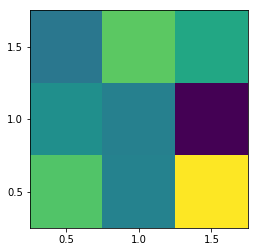

In [4]:
import matplotlib.pyplot as plt

data = np.random.random(size=(3, 3))

plt.imshow(data, interpolation='nearest')
plt.xticks(np.arange(0.0, 2.5, 1), np.arange(0.5, 2, 0.5))
plt.yticks(np.arange(2, -0.5, -1), np.arange(0.5, 2, 0.5))

plt.show()

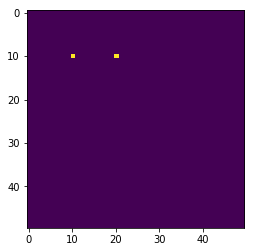

In [8]:
t = np.zeros((50, 50))
t[10, 10] = 1
t[10, 20] = 5
plt.imshow(t, vmin=0, vmax=1, interpolation='nearest')
plt.show()